In [1]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shutil
from osgeo import ogr
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator


sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, delete_items
from scripts.utils.cal_crai_calculations import calculate_equal_weighted_index, add_census_tracts
from scripts.utils.cal_crai_plotting import index_plot, plot_region_domain, plot_hazard_score

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/calcrai_score'
output_folder = 'cal_crai_score_file'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/calcrai_score.


In [3]:
calcrai_score = pd.read_csv(r'cal_crai_score_file/calcrai_score.csv')

In [32]:
keep_columns = ['GEOID', 'hazard_score', 'calcrai_score']
calcrai_plotting_columns = calcrai_score[keep_columns]

# Ensure all values in GEOID are strings
calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].str.zfill(calcrai_plotting_columns['GEOID'].str.len().max() + 1)

calcrai_plotting_columns['hazard_score'] = 1 - calcrai_plotting_columns['hazard_score']

# Display the dataframe
calcrai_plotting_columns

C:\Users\jespi\AppData\Local\Temp\ipykernel_32804\2945581013.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].astype(str)
C:\Users\jespi\AppData\Local\Temp\ipykernel_32804\2945581013.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].str.zfill(calcrai_plotting_columns['GEOID'].str.len().max() + 1)
C:\Users\jespi\AppData\Local\Temp\ipykernel_32804\2945581013.py:10: S

,GEOID,hazard_score,calcrai_score
0,06001400100,0.308160,0.593840
1,06001400200,0.356588,0.520210
2,06001400300,0.298532,0.384277
3,06001400400,0.356800,0.417900
4,06001400500,0.284675,0.350419
...,...,...,...
9124,06115040902,0.684277,1.320288
9125,06115041001,0.705414,1.037047
9126,06115041002,0.694461,1.342894
9127,06115041101,0.721491,1.337257


In [33]:
# Binning into quartiles
binned_equal_df = calcrai_plotting_columns.copy()

# Define the columns to bin
columns_to_bin = [
    'calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_equal_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_equal_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_equal_df = binned_equal_df[['GEOID','calcrai_score_quartile']]
binned_equal_df

Bin edges for calcrai_score: [0.         0.50782468 0.68969808 1.17630724 1.82769235 4.98642604]


,GEOID,calcrai_score_quartile
0,06001400100,1
1,06001400200,1
2,06001400300,0
3,06001400400,0
4,06001400500,0
...,...,...
9124,06115040902,3
9125,06115041001,2
9126,06115041002,3
9127,06115041101,3


In [34]:
# Create a copy and chain the .replace() calls
binned_df_viz = binned_equal_df.copy()
binned_df_viz['calcrai_score_quartile'] = (
    binned_df_viz['calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_df_viz.head()

,GEOID,calcrai_score_quartile
0,06001400100,20-40%
1,06001400200,20-40%
2,06001400300,0-20%
3,06001400400,0-20%
4,06001400500,0-20%


In [35]:
merged_df = pd.merge(calcrai_plotting_columns, binned_df_viz, on='GEOID', how='left')
merged_df

,GEOID,hazard_score,calcrai_score,calcrai_score_quartile
0,06001400100,0.308160,0.593840,20-40%
1,06001400200,0.356588,0.520210,20-40%
2,06001400300,0.298532,0.384277,0-20%
3,06001400400,0.356800,0.417900,0-20%
4,06001400500,0.284675,0.350419,0-20%
...,...,...,...,...
9124,06115040902,0.684277,1.320288,60-80%
9125,06115041001,0.705414,1.037047,40-60%
9126,06115041002,0.694461,1.342894,60-80%
9127,06115041101,0.721491,1.337257,60-80%


In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import box # type: ignore

census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)

In [36]:
# Merge the passed DataFrame with the census boundary data
merged_df = merged_df.merge(ca_boundaries, on='GEOID')
merged_df['geometry'] = merged_df['geometry']
merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry', crs=4269)

In [37]:
la_county = merged_df[merged_df['COUNTYFP'] =='037']

In [38]:
def subplot(df, 
            column, 
            ax=None,
            plot_title=None, 
            cmap='Blues', 
            vmin=None, 
            vmax=None, 
            set_legend=True, 
            legend_position='upper right', 
            legend_bbox=(1, 1), 
            custom_text=None,  
            font_size=16, 
            font_color='white', 
            x_ticks=None, 
            categorical=False,
            exclude_box=(-119, 33, -118, 33.6),
            cbar_label=None):
    
    # Check for invalid geometries
    if len(df) == 0:
        print('No valid geometries. Cannot plot.')
        return

    # Set up the figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 6), layout='compressed')
        created_fig = True
    else:
        created_fig = False

    # Define the bounding box to exclude
    exclusion_box = box(*exclude_box)
    df = df[~df.intersects(exclusion_box)]    

    # Plot the data
    df.plot(column=column, 
            ax=ax, 
            cmap=cmap, 
            vmin=vmin, 
            vmax=vmax, 
            legend=False if categorical else set_legend, 
            categorical=categorical)

    # Add legend or colorbar
    if set_legend and not categorical:
        cbar_ax = ax.figure.add_axes([0.065, 0.5401, 0.23, 0.01])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        cbar = ax.figure.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        if cbar_label:
            cbar.set_label(cbar_label, fontsize=10)
    elif categorical and set_legend:
        ax.legend(title="Composite Resilience", loc=legend_position, bbox_to_anchor=legend_bbox)

    # Set plot title if provided
    if plot_title:
        ax.set_title(plot_title, fontsize=18)

    # Add custom text annotation
    if custom_text:
        ax.text(-118.76, 33.7, custom_text, 
                weight='medium', fontsize=font_size, color=font_color, 
                ha='center', va='center', alpha=1)

    # Customize tick parameters
    ax.tick_params(axis='y', which='major', labelsize=12)
    ax.tick_params(axis='y', which='minor', labelsize=12)
    
    if x_ticks:
        xlim = ax.get_xlim()
        buffer = (xlim[1] - xlim[0]) * 0.05
        adjusted_xlim = (xlim[0] + buffer, xlim[1] - buffer)
        tick_positions = np.linspace(adjusted_xlim[0], adjusted_xlim[1], x_ticks)
        rounded_labels = [round(tick, 1) for tick in tick_positions]
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(rounded_labels)

    # Display the plot if a new figure was created
    if created_fig:
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


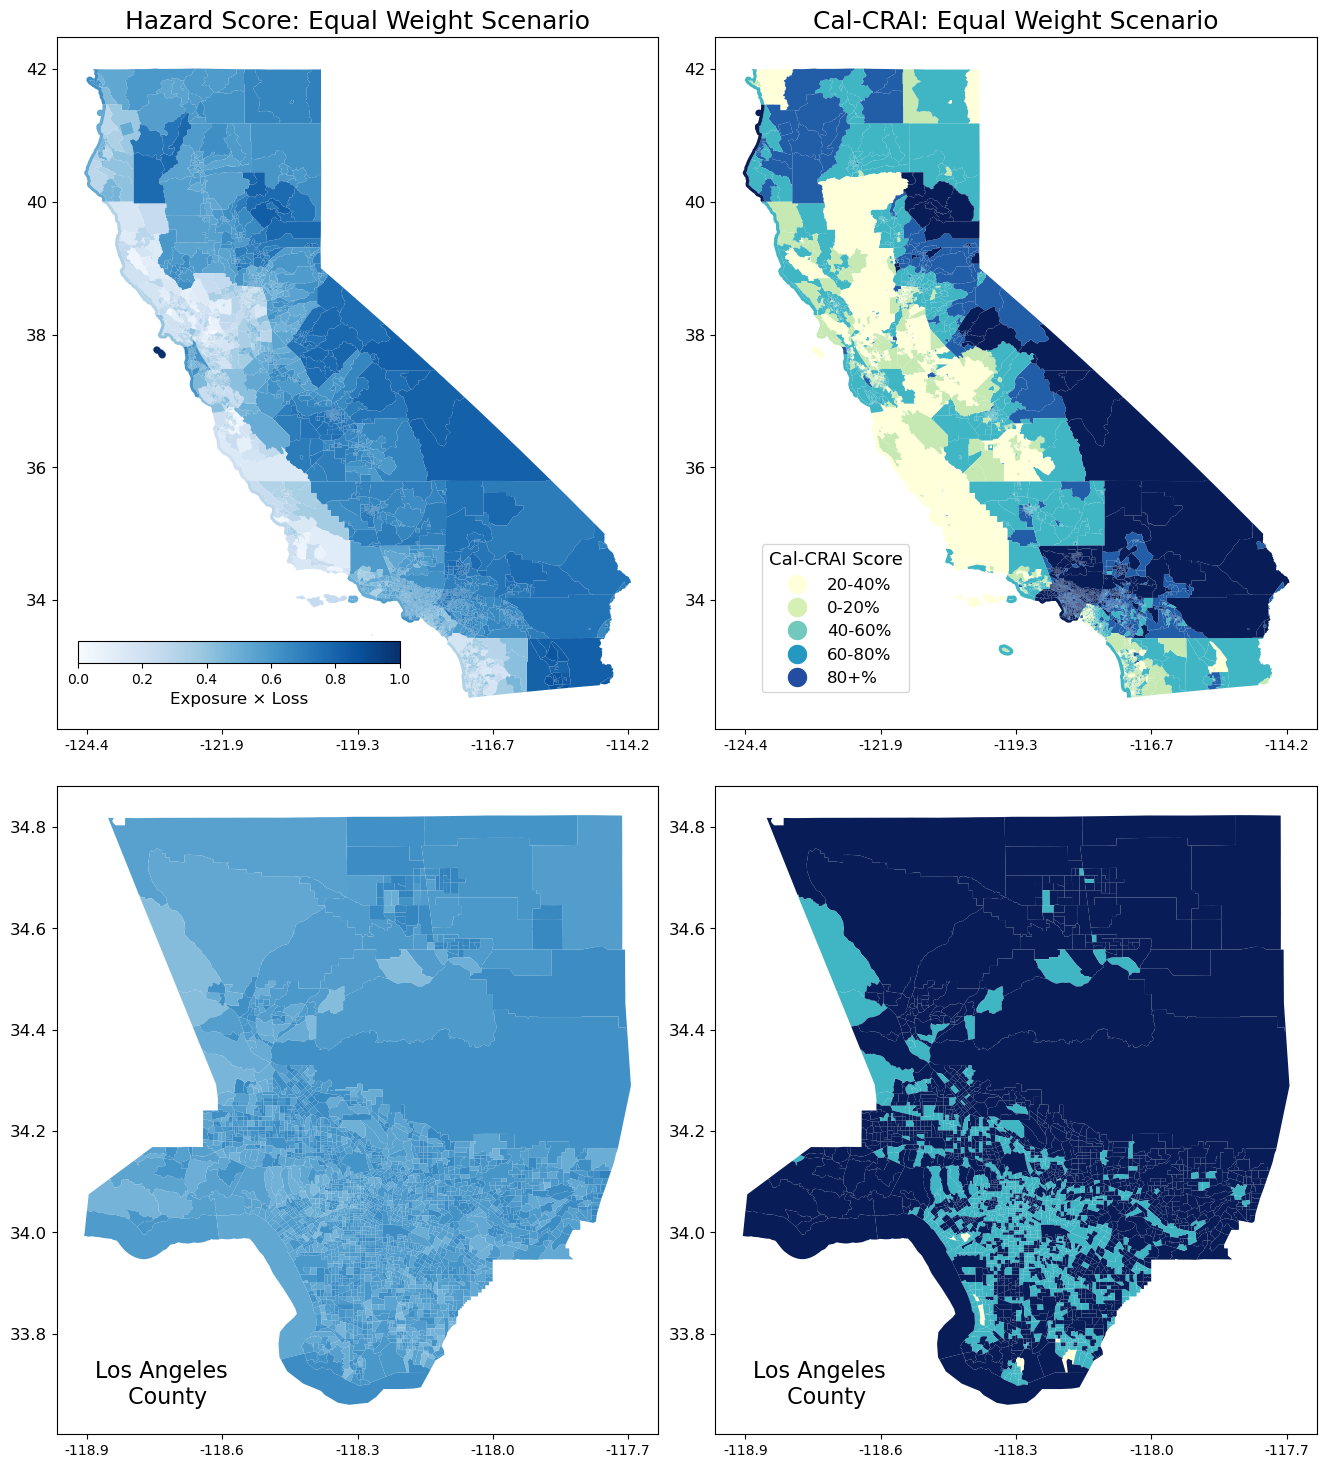

In [39]:
fig = plt.figure(figsize=(14, 22))
gs = plt.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.095, hspace=-0.42)

# Top-left subplot (hazard score)
ax0 = fig.add_subplot(gs[0, 0])
subplot(merged_df, 
             column='hazard_score', 
             plot_title='Hazard Score: Equal Weight Scenario', 
             x_ticks=5, 
             ax=ax0, 
             cmap='Blues', 
             vmin=0, 
             vmax=1, 
             set_legend=False)

cbar_ax = fig.add_axes([0.065, 0.5381, 0.23, 0.01])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []  # Required for the ScalarMappable
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(u'Exposure \u00D7 Loss', fontsize=12)

# Top-right subplot (index plot)
ax1 = fig.add_subplot(gs[0, 1])
subplot(merged_df, 
             column='calcrai_score_quartile', 
             plot_title='Cal-CRAI: Equal Weight Scenario', 
             ax=ax1, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=True, 
             legend_position='center', 
             legend_bbox=(0.2, 0.16), 
             x_ticks=5)

# Manually add legend if not automatically generated
handles, labels = ax1.get_legend_handles_labels()
if not labels:  # If no labels detected, add manually
    unique_values = merged_df['calcrai_score_quartile'].unique()
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(val),
                          markerfacecolor=plt.cm.YlGnBu(i/len(unique_values)), markersize=15)
               for i, val in enumerate(unique_values)]
    ax1.legend(handles=handles, title="Cal-CRAI Score", fontsize=12, title_fontsize=13, loc='center', bbox_to_anchor=(0.2, 0.16))

# Bottom-left subplot (LA hazard score)
ax2 = fig.add_subplot(gs[1, 0])
subplot(la_county, 
             column='hazard_score', 
             ax=ax2, 
             cmap='Blues', 
             vmin=0, 
             vmax=1, 
             set_legend=False, 
             x_ticks=5, 
             custom_text='Los Angeles \n County', 
             font_color='black')

# Bottom-right subplot (LA index plot)
ax3 = fig.add_subplot(gs[1, 1])
subplot(la_county, 
             column='calcrai_score_quartile', 
             ax=ax3, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=False, 
             x_ticks=5, 
             custom_text='Los Angeles \n County', 
             font_color='black')

# Adjust spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Save the figure
fig.savefig('CalCRAI_subplot.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/calcrai_drought_scenario_index.csv'
output_folder = 'cal_crai_score_file'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/calcrai_drought_scenario_index.csv.


In [14]:
drought_weighting = pd.read_csv('cal_crai_score_file/calcrai_drought_scenario_index.csv')

In [15]:
drought_weighting

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_environment_tract_adjusted,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score,weighted_community_capacity,drought_scenario_calcrai_score
0,6001400100,0.384966,0.605062,0.589375,0.833488,0.642475,0.582181,0.748805,0.012357,0.113091,-0.058232,0.691840,0.878232,0.769035,0.617510,0.167432,0.546436,0.401674,0.457367
1,6001400200,0.384966,0.553534,0.514427,0.841855,0.642475,0.582181,0.748805,-0.116380,0.124264,-0.138434,0.643412,0.878232,0.792429,0.409643,0.172773,0.605283,0.365592,0.416282
2,6001400300,0.384966,0.557473,0.450082,0.793298,0.642475,0.582181,0.748805,-0.226903,0.059419,-0.132304,0.701468,0.852784,0.828517,0.614542,0.161103,0.605283,0.337680,0.395974
3,6001400400,0.384966,0.549355,0.474044,0.770451,0.642475,0.582181,0.748805,-0.185744,0.028908,-0.144939,0.643200,0.852784,0.828517,0.406913,0.167674,0.605283,0.326402,0.382749
4,6001400500,0.384966,0.552923,0.463199,0.744977,0.642475,0.582181,0.748805,-0.204372,-0.005111,-0.139386,0.715325,0.852784,0.828517,0.614532,0.170886,0.605283,0.315796,0.370311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.506516,0.468943,0.609509,0.783342,0.642475,0.582181,0.748805,0.046941,0.046124,-0.270099,0.315723,0.324800,0.382787,0.619160,NaN,0.846492,0.401398,1.235830
9125,6115041001,0.455906,0.416459,0.599682,0.742681,0.642475,0.582181,0.748805,0.030061,-0.008179,-0.351789,0.294586,0.311958,0.374011,0.527876,NaN,0.873744,0.303251,0.972087
9126,6115041002,0.541790,0.432561,0.616996,0.766956,0.642475,0.582181,0.748805,0.059802,0.024240,-0.326726,0.305539,0.322660,0.377173,0.585439,NaN,0.819991,0.391591,1.213633
9127,6115041101,0.503268,0.391202,0.668231,0.736324,0.642475,0.582181,0.748805,0.147807,-0.016668,-0.391102,0.278509,0.353338,0.322773,0.539505,NaN,0.651207,0.324772,0.919153


In [40]:
keep_columns = ['GEOID', 'drought_hazard_score', 'drought_scenario_calcrai_score']
calcrai_drought_plotting_columns = drought_weighting[keep_columns]

# Ensure all values in GEOID are strings
calcrai_drought_plotting_columns['GEOID'] = calcrai_drought_plotting_columns['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
calcrai_drought_plotting_columns['GEOID'] = calcrai_drought_plotting_columns['GEOID'].str.zfill(calcrai_drought_plotting_columns['GEOID'].str.len().max() + 1)

calcrai_drought_plotting_columns['drought_hazard_score'] = 1 - calcrai_drought_plotting_columns['drought_hazard_score']

# Display the dataframe
calcrai_drought_plotting_columns

C:\Users\jespi\AppData\Local\Temp\ipykernel_32804\3877455671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_drought_plotting_columns['GEOID'] = calcrai_drought_plotting_columns['GEOID'].astype(str)
C:\Users\jespi\AppData\Local\Temp\ipykernel_32804\3877455671.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_drought_plotting_columns['GEOID'] = calcrai_drought_plotting_columns['GEOID'].str.zfill(calcrai_drought_plotting_columns['GEOID'].str.len().max() + 1)
C:\Users\jespi\AppData\Local\

,GEOID,drought_hazard_score,drought_scenario_calcrai_score
0,06001400100,0.121768,0.457367
1,06001400200,0.121768,0.416282
2,06001400300,0.147216,0.395974
3,06001400400,0.147216,0.382749
4,06001400500,0.147216,0.370311
...,...,...,...
9124,06115040902,0.675200,1.235830
9125,06115041001,0.688042,0.972087
9126,06115041002,0.677340,1.213633
9127,06115041101,0.646662,0.919153


In [41]:
# Binning into quartiles
binned_drought_df = calcrai_drought_plotting_columns.copy()

# Define the columns to bin
columns_to_bin = [
    'drought_scenario_calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_drought_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_drought_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_drought_df = binned_drought_df[['GEOID','drought_scenario_calcrai_score_quartile']]
binned_drought_df

Bin edges for drought_scenario_calcrai_score: [ 0.          0.52652309  1.02915265  1.60722415  2.11176125 21.93983521]


,GEOID,drought_scenario_calcrai_score_quartile
0,06001400100,0
1,06001400200,0
2,06001400300,0
3,06001400400,0
4,06001400500,0
...,...,...
9124,06115040902,2
9125,06115041001,1
9126,06115041002,2
9127,06115041101,1


In [42]:
# Create a copy and chain the .replace() calls
binned_drought_df_viz = binned_drought_df.copy()
binned_drought_df_viz['calcrai_drought_score_quartile'] = (
    binned_drought_df_viz['drought_scenario_calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_drought_df_viz.tail()

,GEOID,drought_scenario_calcrai_score_quartile,calcrai_drought_score_quartile
9124,06115040902,2,40-60%
9125,06115041001,1,20-40%
9126,06115041002,2,40-60%
9127,06115041101,1,20-40%
9128,06115041102,2,40-60%


In [43]:
merged_drought_df = pd.merge(calcrai_drought_plotting_columns, binned_drought_df_viz, on='GEOID', how='left')
merged_drought_df

,GEOID,drought_hazard_score,drought_scenario_calcrai_score,drought_scenario_calcrai_score_quartile,calcrai_drought_score_quartile
0,06001400100,0.121768,0.457367,0,0-20%
1,06001400200,0.121768,0.416282,0,0-20%
2,06001400300,0.147216,0.395974,0,0-20%
3,06001400400,0.147216,0.382749,0,0-20%
4,06001400500,0.147216,0.370311,0,0-20%
...,...,...,...,...,...
9124,06115040902,0.675200,1.235830,2,40-60%
9125,06115041001,0.688042,0.972087,1,20-40%
9126,06115041002,0.677340,1.213633,2,40-60%
9127,06115041101,0.646662,0.919153,1,20-40%


In [44]:
# Merge the passed DataFrame with the census boundary data
merged_drought_df_ca_boundries = merged_drought_df.merge(ca_boundaries, on='GEOID')
merged_drought_df_ca_boundries['geometry'] = merged_drought_df_ca_boundries['geometry']
merged_drought_df_ca_boundries = gpd.GeoDataFrame(merged_drought_df_ca_boundries, geometry='geometry', crs=4269)

In [45]:
merged_drought_df_ca_boundries

,GEOID,drought_hazard_score,drought_scenario_calcrai_score,drought_scenario_calcrai_score_quartile,calcrai_drought_score_quartile,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06001400100,0.121768,0.457367,0,0-20%,06,001,400100,4001,Census Tract 4001,G5020,S,6945856,0,+37.8676563,-122.2318813,"POLYGON ((-122.24691 37.88535, -122.24665 37.8..."
1,06001400200,0.121768,0.416282,0,0-20%,06,001,400200,4002,Census Tract 4002,G5020,S,586560,0,+37.8481378,-122.2495916,"POLYGON ((-122.25792 37.84261, -122.25773 37.8..."
2,06001400300,0.147216,0.395974,0,0-20%,06,001,400300,4003,Census Tract 4003,G5020,S,1110840,0,+37.8405841,-122.2544782,"POLYGON ((-122.26563 37.83764, -122.26556 37.8..."
3,06001400400,0.147216,0.382749,0,0-20%,06,001,400400,4004,Census Tract 4004,G5020,S,716138,0,+37.8482840,-122.2574447,"POLYGON ((-122.26183 37.84162, -122.26180 37.8..."
4,06001400500,0.147216,0.370311,0,0-20%,06,001,400500,4005,Census Tract 4005,G5020,S,591424,0,+37.8485452,-122.2647353,"POLYGON ((-122.26951 37.84858, -122.26937 37.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.675200,1.235830,2,40-60%,06,115,040902,409.02,Census Tract 409.02,G5020,S,93603063,240059,+39.1193450,-121.3995842,"POLYGON ((-121.47722 39.13333, -121.47709 39.1..."
9125,06115041001,0.688042,0.972087,1,20-40%,06,115,041001,410.01,Census Tract 410.01,G5020,S,275920634,1720985,+39.2634436,-121.5062545,"POLYGON ((-121.63637 39.24608, -121.63629 39.2..."
9126,06115041002,0.677340,1.213633,2,40-60%,06,115,041002,410.02,Census Tract 410.02,G5020,S,192476772,5206412,+39.2923343,-121.3205968,"POLYGON ((-121.46947 39.33348, -121.46900 39.3..."
9127,06115041101,0.646662,0.919153,1,20-40%,06,115,041101,411.01,Census Tract 411.01,G5020,S,464905359,16529900,+39.4752686,-121.1718725,"POLYGON ((-121.37257 39.37358, -121.37253 39.3..."


In [46]:
la_county_drought = merged_drought_df_ca_boundries[merged_drought_df_ca_boundries['COUNTYFP'] =='037']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


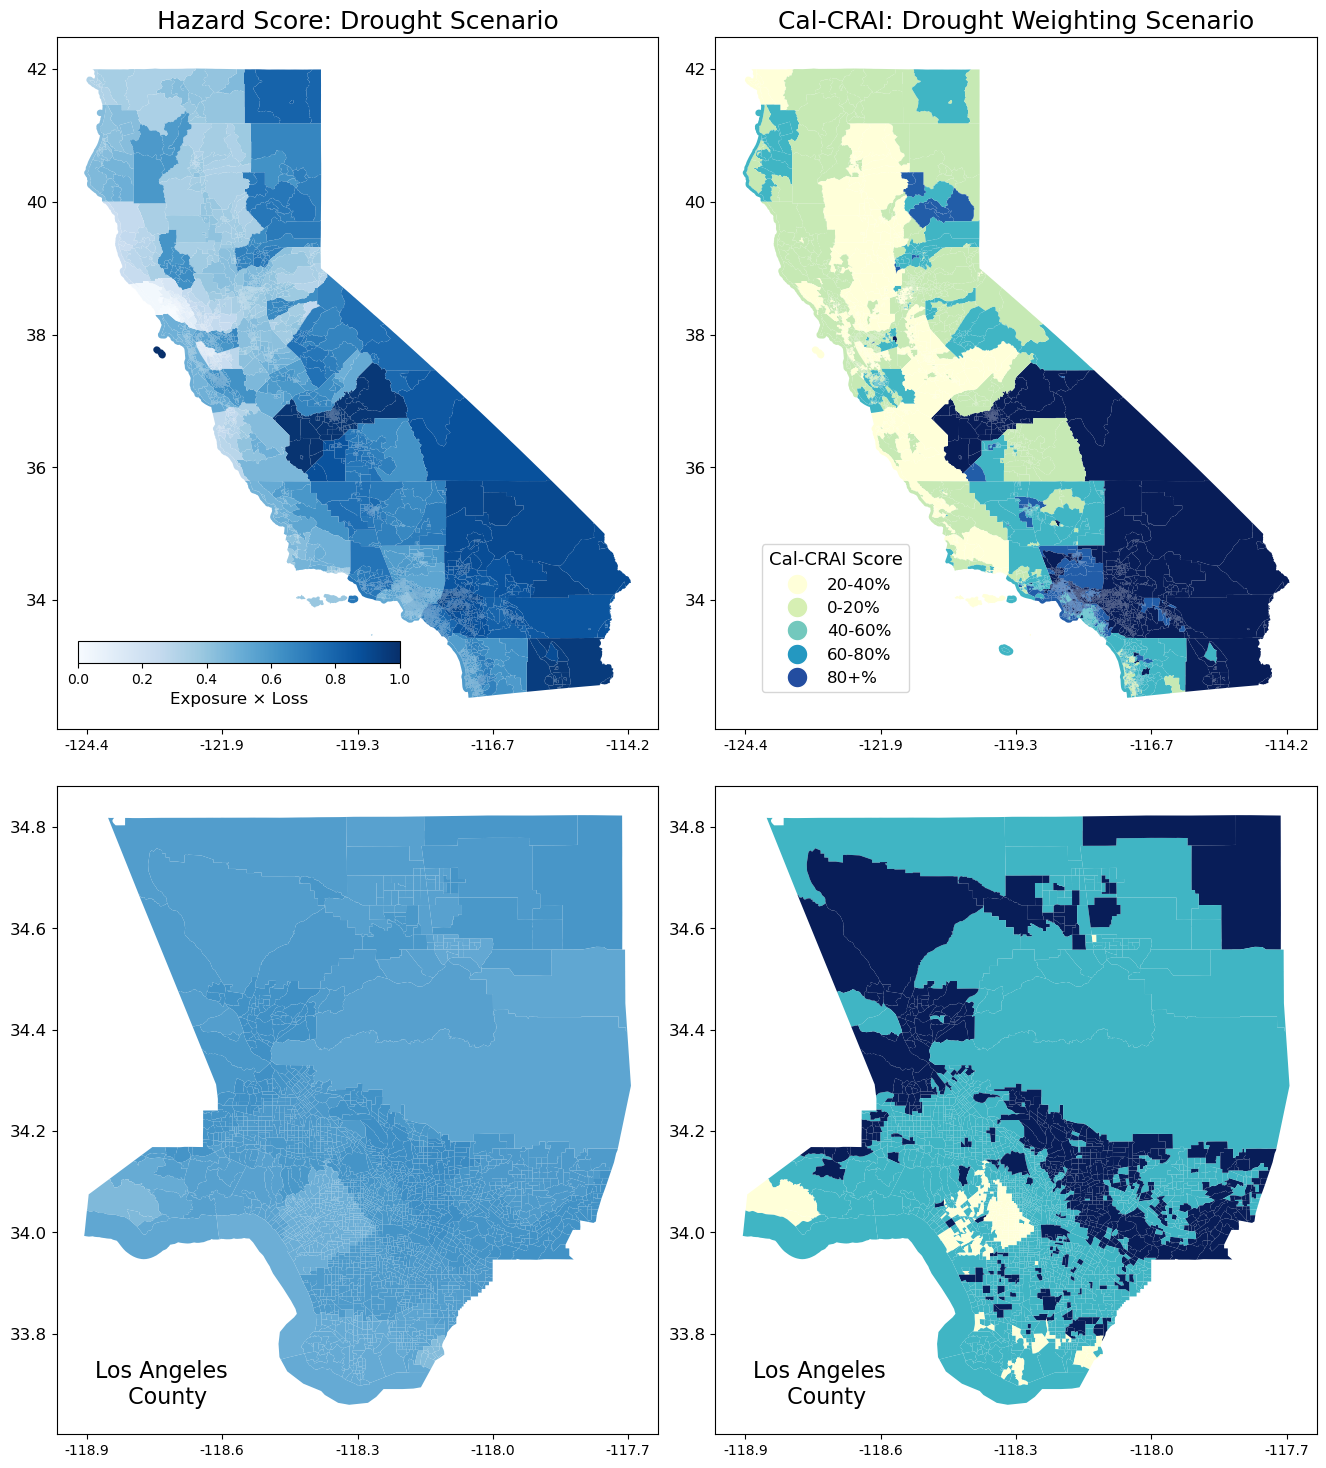

In [47]:
fig = plt.figure(figsize=(14, 22))
gs = plt.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.095, hspace=-0.42)

# Top-left subplot (hazard score)
ax0 = fig.add_subplot(gs[0, 0])
subplot(merged_drought_df_ca_boundries, 
             column='drought_hazard_score', 
             plot_title='Hazard Score: Drought Scenario', 
             x_ticks=5, 
             ax=ax0, 
             cmap='Blues', 
             vmin=0, 
             vmax=1, 
             set_legend=False)

cbar_ax = fig.add_axes([0.065, 0.5381, 0.23, 0.01])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []  # Required for the ScalarMappable
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(u'Exposure \u00D7 Loss', fontsize=12)

# Top-right subplot (index plot)
ax1 = fig.add_subplot(gs[0, 1])
subplot(merged_drought_df_ca_boundries, 
             column='calcrai_drought_score_quartile', 
             plot_title='Cal-CRAI: Drought Weighting Scenario', 
             ax=ax1, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=True, 
             legend_position='center', 
             legend_bbox=(0.2, 0.16), 
             x_ticks=5)

# Manually add legend if not automatically generated
handles, labels = ax1.get_legend_handles_labels()
if not labels:  # If no labels detected, add manually
    unique_values = merged_df['calcrai_score_quartile'].unique()
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(val),
                          markerfacecolor=plt.cm.YlGnBu(i/len(unique_values)), markersize=15)
               for i, val in enumerate(unique_values)]
    ax1.legend(handles=handles, title="Cal-CRAI Score", fontsize=12, title_fontsize=13, loc='center', bbox_to_anchor=(0.2, 0.16))

# Bottom-left subplot (LA hazard score)
ax2 = fig.add_subplot(gs[1, 0])
subplot(la_county_drought, 
             column='drought_hazard_score', 
             ax=ax2, 
             cmap='Blues', 
             vmin=0, 
             vmax=1, 
             set_legend=False, 
             x_ticks=5, 
             custom_text='Los Angeles \n County', 
             font_color='black')

# Bottom-right subplot (LA index plot)
ax3 = fig.add_subplot(gs[1, 1])
subplot(la_county_drought, 
             column='calcrai_drought_score_quartile', 
             ax=ax3, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=False, 
             x_ticks=5, 
             custom_text='Los Angeles \n County', 
             font_color='black')

# Adjust spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Save the figure
fig.savefig('CalCRAI_drought_subplot.png', dpi=300, bbox_inches='tight')
plt.show()


In [25]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/climate_hazard_scores'
output_folder = 'cal_crai_score_file'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/climate_hazard_scores.
